In [1]:
import numpy as np
import pandas as pd
import tables

In [2]:
INPUT_DIR = '../../input/m5-forecasting-accuracy/'
OUTPUT_DIR =  '../../input/lv9/'

## 日付に関する情報

In [3]:
cal = pd.read_csv(INPUT_DIR+'calendar.csv')

In [4]:
# week day feature

# add big sports event
superbowl_days = ['2016-01-09','2016-01-10','2016-01-16','2016-01-17', '2016-01-24',  '2016-01-31', '2016-02-07',
'2015-01-03','2015-01-04','2015-01-10','2015-01-11','2015-01-18','2015-01-25','2015-02-01',
 '2014-01-04','2014-01-05','2014-01-11','2014-01-12','2014-01-19','2014-01-26','2014-02-02',
'2013-01-05','2013-01-06','2013-01-12','2013-01-13','2013-01-20','2013-01-27','2013-02-03',
'2012-01-07','2012-01-08','2012-01-14','2012-01-15','2012-01-22','2012-01-29','2012-02-05',
'2011-01-30','2011-02-06']
cal.loc[cal['date'].isin(superbowl_days),'sports']=1

nba_days = ['2013-06-06','2013-06-09','2013-06-10','2013-06-11','2013-06-13','2013-06-16','2013-06-18','2013-06-20',
 '2014-06-05','2014-06-08','2014-06-10','2014-06-12','2014-06-15',
 '2015-06-04','2015-06-07','2015-06-09','2015-06-11','2015-06-14','2015-06-16',
'2016-06-02','2016-06-05','2016-06-08','2016-06-10','2016-06-13','2016-06-16','2016-06-19']
cal.loc[cal['date'].isin(nba_days),'sports']=1

# add Ramadan
Ramadan_days= []
Ramadan_end =['2011-08-29','2012-08-18','2013-08-07','2014-07-27','2015-07-16','2016-06-19']
for i,t in zip(cal[cal['event_name_1']=='Ramadan starts'].index.tolist(),cal[cal['date'].isin(Ramadan_end)].index.tolist()):
    Ramadan_days.extend(pd.DatetimeIndex(cal['date'].iloc[i:(t+1)]).tolist())
_Ramadan_days = pd.DatetimeIndex(Ramadan_days)
Ramadan_days = [str(days)[:10] for days in _Ramadan_days]
cal.loc[cal['date'].isin(Ramadan_days),'ramadan']=1

# black friday
black_friday_days = ['2011-11-25', '2012-11-23', '2013-11-29', '2014-11-28', '2015-11-27']
cal.loc[cal['date'].isin(black_friday_days),'event_name_1']='black_friday'

# Eid_ul_Fitr_day
Eid_ul_Fitr_days = ['2011-08-30','2012-08-19','2013-08-08','2014-07-28','2015-07-17','2016-06-20']
cal.loc[cal['date'].isin(Eid_ul_Fitr_days),'event_name_1']='Eid_ul_Fitr_day'

In [5]:
cal_ = cal.loc[:,['wday','month','event_name_1','sports','ramadan','snap_CA','snap_TX','snap_WI']]
cal_['day_type'] = cal_['wday'].map({1: 5,2:6,3: 0,4:2,5:2,6:2,7:4})
cal_.loc[cal_['event_name_1'].isna(), 'holi_bool'] = 0
cal_.loc[~cal_['event_name_1'].isna(), 'holi_bool'] = 1
cal_['holi_-1'] = cal_["holi_bool"].shift(1)
cal_['holi_1'] = cal_["holi_bool"].shift(-1)
cal_.loc[cal_['holi_-1']==1, 'day_type'] = 8
cal_.loc[cal_['holi_1']==1, 'day_type'] = 8
cal_.loc[cal_['holi_bool']==1, 'day_type'] = 7
cal_ = cal_.fillna(0)
cal_.drop(['month','event_name_1','holi_bool','holi_-1','holi_1'], axis=1, inplace=True)

In [6]:
cal_feat = cal_.T

In [7]:
cal_feat.columns = [f'd_{i+1}' for i in range(1969)]

In [8]:
cal_feat

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
wday,1.0,2.0,3.0,4.0,5.0,6.0,7.0,1.0,2.0,3.0,...,7.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,1.0,2.0
sports,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
ramadan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
snap_CA,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
snap_TX,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
snap_WI,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
day_type,5.0,6.0,0.0,2.0,2.0,2.0,4.0,8.0,7.0,8.0,...,4.0,5.0,6.0,0.0,2.0,2.0,2.0,4.0,8.0,7.0


## 値段/売り上げに関する特徴

In [9]:
price_df = pd.read_csv(INPUT_DIR+'sell_prices.csv')
cal_df = pd.read_csv(INPUT_DIR+'calendar.csv')
sales = pd.read_csv(INPUT_DIR+'sales_train_evaluation.csv')

In [10]:
# 目的変数
sales_lv9 = sales.groupby(['dept_id','store_id']).sum()

In [11]:
sales_lv9

d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  ...  \
dept_id     store_id                                                     ...   
FOODS_1     CA_1      297  284  214  175  182  191  224  263  245   176  ...   
            CA_2      406  408  238  240  220  263  304  353  313   272  ...   
            CA_3      341  326  260  231  220  258  285  309  404   290  ...   
            CA_4      113  124   75   97  107   84  100  111   87    66  ...   
            TX_1      152  154  109  126  108  153   72  126  119    95  ...   
...                   ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...   
HOUSEHOLD_2 TX_2      199  183  117  108   98  110  133  200  188   147  ...   
            TX_3      120  138   97   83   46  102  120  141  135    94  ...   
            WI_1      148  151   66   47    0  105  126  186   96    84  ...   
            WI_2       98   94   69   80   32  107  100  111   63    66  ...   
            WI_3      148  195  106   94   53  122  159  186  119   108  ...   

                      d_1932  d_1933  d_1934  d_1935  d_1936  d_1937  d_1938  \
dept_id     store_id                                                           
FOODS_1     CA_1         412     435     415     277     302     397     330   
            CA_2         683     628     598     468     389     388     404   
            CA_3         552     497     565     377     382     345     408   
            CA_4         284     294     242     286     243     244     222   
            TX_1         239     281     316     261     235     241     220   
...                      ...     ...     ...     ...     ...     ...     ...   
HOUSEHOLD_2 TX_2         204     236     267     185     170     176     167   
            TX_3         194     235     226     183     203     157     174   
            WI_1         154     233     235     140     164     138     175   
            WI_2         154     184     177     145     138     157     198   
            WI_3         164     205     194     138     132     133     141   

                      d_1939  d_1940  d_1941  
dept_id     store_id                          
FOODS_1     CA_1         310     427     334  
            CA_2         584     809     735  
            CA_3         457     574     651  
            CA_4         280     285     321  
            TX_1         299     279     398  
...                      ...     ...     ...  
HOUSEHOLD_2 TX_2         254     246     275  
            TX_3         202     213     220  
            WI_1         180     250     246  
            WI_2         174     192     196  
            WI_3         230     218     208  

[70 rows x 1941 columns]

In [12]:
price_cal = pd.merge(price_df, cal_df.loc[:,['wm_yr_wk', 'd']], on='wm_yr_wk')

In [13]:
price_cal['dept_id'] = price_cal.item_id.apply(lambda x: x[:-4])

In [14]:
price_cal

,store_id,item_id,wm_yr_wk,sell_price,d,dept_id
0,CA_1,HOBBIES_1_001,11325,9.58,d_897,HOBBIES_1
1,CA_1,HOBBIES_1_001,11325,9.58,d_898,HOBBIES_1
2,CA_1,HOBBIES_1_001,11325,9.58,d_899,HOBBIES_1
3,CA_1,HOBBIES_1_001,11325,9.58,d_900,HOBBIES_1
4,CA_1,HOBBIES_1_001,11325,9.58,d_901,HOBBIES_1
...,...,...,...,...,...,...
47735392,WI_3,FOODS_3_825,11105,4.00,d_31,FOODS_3
47735393,WI_3,FOODS_3_825,11105,4.00,d_32,FOODS_3
47735394,WI_3,FOODS_3_825,11105,4.00,d_33,FOODS_3
47735395,WI_3,FOODS_3_825,11105,4.00,d_34,FOODS_3


In [15]:
price_cnt_sum = price_cal.groupby(['store_id','dept_id','d']).agg(['count','sum'])['sell_price']

In [16]:
price_cnt_sum

count      sum
store_id dept_id     d                     
CA_1     FOODS_1     d_1       101   301.90
                     d_10      107   322.78
                     d_100     121   361.53
                     d_1000    204   660.55
                     d_1001    204   660.55
...                            ...      ...
WI_3     HOUSEHOLD_2 d_995     436  2530.48
                     d_996     436  2530.48
                     d_997     436  2530.48
                     d_998     436  2530.48
                     d_999     436  2530.48

[137830 rows x 2 columns]

In [17]:
price_cnt_sum.unstack(level='d')

count                                                \
d                      d_1 d_10 d_100 d_1000 d_1001 d_1002 d_1003 d_1004   
store_id dept_id                                                           
CA_1     FOODS_1       101  107   121    204    204    204    204    204   
         FOODS_2       189  197   217    322    322    322    322    322   
         FOODS_3       338  359   430    695    695    695    695    695   
         HOBBIES_1     161  173   200    375    375    375    375    375   
         HOBBIES_2      33   48    74    124    124    124    124    124   
...                    ...  ...   ...    ...    ...    ...    ...    ...   
WI_3     FOODS_3       339  355   420    687    687    687    687    687   
         HOBBIES_1     165  177   204    376    376    376    376    376   
         HOBBIES_2      29   45    74    123    123    123    123    123   
         HOUSEHOLD_1   163  177   225    440    440    440    440    440   
         HOUSEHOLD_2   206  234   309    436    436    437    437    437   

                                    ...      sum                             \
d                    d_1005 d_1006  ...    d_990    d_991    d_992    d_993   
store_id dept_id                    ...                                       
CA_1     FOODS_1        204    204  ...   658.57   658.57   658.57   658.57   
         FOODS_2        322    322  ...  1342.81  1342.81  1342.81  1342.81   
         FOODS_3        695    695  ...  1967.61  1967.61  1967.61  1967.61   
         HOBBIES_1      375    375  ...  2375.45  2375.45  2375.45  2375.45   
         HOBBIES_2      124    124  ...   335.01   335.01   335.01   335.01   
...                     ...    ...  ...      ...      ...      ...      ...   
WI_3     FOODS_3        687    687  ...  1917.74  1917.74  1917.74  1917.74   
         HOBBIES_1      376    376  ...  2387.74  2387.74  2387.74  2387.74   
         HOBBIES_2      123    123  ...   332.54   332.54   332.54   332.54   
         HOUSEHOLD_1    440    440  ...  2174.11  2174.11  2174.11  2174.11   
         HOUSEHOLD_2    437    437  ...  2521.44  2521.44  2521.44  2521.44   

                                                                            
d                       d_994    d_995    d_996    d_997    d_998    d_999  
store_id dept_id                                                            
CA_1     FOODS_1       658.57   660.55   660.55   660.55   660.55   660.55  
         FOODS_2      1342.81  1342.81  1342.81  1342.81  1342.81  1342.81  
         FOODS_3      1967.61  1970.11  1970.11  1970.11  1970.11  1970.11  
         HOBBIES_1    2375.45  2375.57  2375.57  2375.57  2375.57  2375.57  
         HOBBIES_2     335.01   335.01   335.01   335.01   335.01   335.01  
...                       ...      ...      ...      ...      ...      ...  
WI_3     FOODS_3      1917.74  1924.62  1924.62  1924.62  1924.62  1924.62  
         HOBBIES_1    2387.74  2387.74  2387.74  2387.74  2387.74  2387.74  
         HOBBIES_2     332.54   332.54   332.54   332.54   332.54   332.54  
         HOUSEHOLD_1  2174.11  2186.74  2186.74  2186.74  2186.74  2186.74  
         HOUSEHOLD_2  2521.44  2530.48  2530.48  2530.48  2530.48  2530.48  

[70 rows x 3938 columns]

In [18]:
price_cnt = price_cnt_sum.unstack(level='d').loc[:,'count']

In [19]:
price_cnt = price_cnt.loc[:,[f'd_{i+1}' for i in range(1969)]]

In [20]:
# 日付ごとの合計商品数
price_cnt

d                     d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  ...  \
store_id dept_id                                                         ...   
CA_1     FOODS_1      101  101  101  101  101  101  101  107  107   107  ...   
         FOODS_2      189  189  189  189  189  189  189  197  197   197  ...   
         FOODS_3      338  338  338  338  338  338  338  359  359   359  ...   
         HOBBIES_1    161  161  161  161  161  161  161  173  173   173  ...   
         HOBBIES_2     33   33   33   33   33   33   33   48   48    48  ...   
...                   ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...   
WI_3     FOODS_3      339  339  339  339  339  339  339  355  355   355  ...   
         HOBBIES_1    165  165  165  165  165  165  165  177  177   177  ...   
         HOBBIES_2     29   29   29   29   29   29   29   45   45    45  ...   
         HOUSEHOLD_1  163  163  163  163  163  163  163  177  177   177  ...   
         HOUSEHOLD_2  206  206  206  206  206  206  206  234  234   234  ...   

d                     d_1960  d_1961  d_1962  d_1963  d_1964  d_1965  d_1966  \
store_id dept_id                                                               
CA_1     FOODS_1         216     216     216     216     216     216     216   
         FOODS_2         398     398     398     398     398     398     398   
         FOODS_3         823     823     823     823     823     823     823   
         HOBBIES_1       416     416     416     416     416     416     416   
         HOBBIES_2       149     149     149     149     149     149     149   
...                      ...     ...     ...     ...     ...     ...     ...   
WI_3     FOODS_3         823     823     823     823     823     823     823   
         HOBBIES_1       416     416     416     416     416     416     416   
         HOBBIES_2       149     149     149     149     149     149     149   
         HOUSEHOLD_1     532     532     532     532     532     532     532   
         HOUSEHOLD_2     515     515     515     515     515     515     515   

d                     d_1967  d_1968  d_1969  
store_id dept_id                              
CA_1     FOODS_1         216     216     216  
         FOODS_2         398     398     398  
         FOODS_3         823     823     823  
         HOBBIES_1       416     416     416  
         HOBBIES_2       149     149     149  
...                      ...     ...     ...  
WI_3     FOODS_3         823     823     823  
         HOBBIES_1       416     416     416  
         HOBBIES_2       149     149     149  
         HOUSEHOLD_1     532     532     532  
         HOUSEHOLD_2     515     515     515  

[70 rows x 1969 columns]

In [21]:
price_sum = price_cnt_sum.unstack(level='d').loc[:,'sum']
price_sum = price_sum.loc[:,[f'd_{i+1}' for i in range(1969)]]

In [22]:
# 日付ごとの合計金額
price_sum

d                         d_1      d_2      d_3      d_4      d_5      d_6  \
store_id dept_id                                                             
CA_1     FOODS_1       301.90   301.90   301.90   301.90   301.90   301.90   
         FOODS_2       719.61   719.61   719.61   719.61   719.61   719.61   
         FOODS_3       956.20   956.20   956.20   956.20   956.20   956.20   
         HOBBIES_1     768.52   768.52   768.52   768.52   768.52   768.52   
         HOBBIES_2      98.43    98.43    98.43    98.43    98.43    98.43   
...                       ...      ...      ...      ...      ...      ...   
WI_3     FOODS_3       883.56   883.56   883.56   883.56   883.56   883.56   
         HOBBIES_1     801.15   801.15   801.15   801.15   801.15   801.15   
         HOBBIES_2      76.36    76.36    76.36    76.36    76.36    76.36   
         HOUSEHOLD_1   815.50   815.50   815.50   815.50   815.50   815.50   
         HOUSEHOLD_2  1126.54  1126.54  1126.54  1126.54  1126.54  1126.54   

d                         d_7      d_8      d_9     d_10  ...   d_1960  \
store_id dept_id                                          ...            
CA_1     FOODS_1       301.90   322.78   322.78   322.78  ...   720.34   
         FOODS_2       719.61   763.54   763.54   763.54  ...  1684.38   
         FOODS_3       956.20  1004.38  1004.38  1004.38  ...  2408.03   
         HOBBIES_1     768.52   838.63   838.63   838.63  ...  2758.28   
         HOBBIES_2      98.43   135.21   135.21   135.21  ...   384.10   
...                       ...      ...      ...      ...  ...      ...   
WI_3     FOODS_3       883.56   940.50   940.50   940.50  ...  2396.03   
         HOBBIES_1     801.15   900.88   900.88   900.88  ...  2751.91   
         HOBBIES_2      76.36   125.61   125.61   125.61  ...   384.10   
         HOUSEHOLD_1   815.50   897.92   897.92   897.92  ...  2752.75   
         HOUSEHOLD_2  1126.54  1314.56  1314.56  1314.56  ...  2969.06   

d                      d_1961   d_1962   d_1963   d_1964   d_1965   d_1966  \
store_id dept_id                                                             
CA_1     FOODS_1       720.59   720.59   720.59   720.59   720.59   720.59   
         FOODS_2      1684.94  1684.94  1684.94  1684.94  1684.94  1684.94   
         FOODS_3      2408.51  2408.51  2408.51  2408.51  2408.51  2408.51   
         HOBBIES_1    2757.89  2757.89  2757.89  2757.89  2757.89  2757.89   
         HOBBIES_2     384.10   384.10   384.10   384.10   384.10   384.10   
...                       ...      ...      ...      ...      ...      ...   
WI_3     FOODS_3      2396.61  2396.61  2396.61  2396.61  2396.61  2396.61   
         HOBBIES_1    2749.04  2749.04  2749.04  2749.04  2749.04  2749.04   
         HOBBIES_2     384.10   384.10   384.10   384.10   384.10   384.10   
         HOUSEHOLD_1  2757.61  2757.61  2757.61  2757.61  2757.61  2757.61   
         HOUSEHOLD_2  2970.42  2970.42  2970.42  2970.42  2970.42  2970.42   

d                      d_1967   d_1968   d_1969  
store_id dept_id                                 
CA_1     FOODS_1       720.59   720.53   720.53  
         FOODS_2      1684.94  1686.62  1686.62  
         FOODS_3      2408.51  2408.41  2408.41  
         HOBBIES_1    2757.89  2754.89  2754.89  
         HOBBIES_2     384.10   384.10   384.10  
...                       ...      ...      ...  
WI_3     FOODS_3      2396.61  2396.61  2396.61  
         HOBBIES_1    2749.04  2749.04  2749.04  
         HOBBIES_2     384.10   384.10   384.10  
         HOUSEHOLD_1  2757.61  2758.49  2758.49  
         HOUSEHOLD_2  2970.42  2973.96  2973.96  

[70 rows x 1969 columns]

In [23]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [24]:
store_list = sales['store_id'].value_counts().index.tolist()
store_list.sort()
dept_list = sales['dept_id'].value_counts().index.tolist()
dept_list.sort()

In [25]:
print(store_list)
print(dept_list)

['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
['FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2']


In [26]:
# remove Christmas
cal_feat = cal_feat.drop(['d_332','d_697','d_1062','d_1427','d_1792'],axis=1)
price_cnt = price_cnt.drop(['d_332','d_697','d_1062','d_1427','d_1792'],axis=1)
price_sum = price_sum.drop(['d_332','d_697','d_1062','d_1427','d_1792'],axis=1)
sales_lv9 = sales_lv9.drop(['d_332','d_697','d_1062','d_1427','d_1792'],axis=1)

In [27]:
# make array for input
feat_array = np.zeros([70,7,1964])
sales_array = np.zeros([70,1,1936])

idx = 0
for store in store_list:
    if store[:2]=='CA':
        tmp_cal_feat = cal_feat.drop(['snap_TX','snap_WI'])
    elif store[:2]=='TX':
        tmp_cal_feat = cal_feat.drop(['snap_CA','snap_WI'])
    else:
        tmp_cal_feat = cal_feat.drop(['snap_CA','snap_TX'])
    for dept in dept_list:
        feat_array[idx,:5] = tmp_cal_feat
        feat_array[idx,5] = price_cnt.loc[store,dept].values
        feat_array[idx,6] = price_sum.loc[store,dept].values
        
        sales_array[idx] = sales_lv9.loc[dept,store].values
        
        idx+=1

In [29]:
sales_array

array([[[ 297.,  284.,  214., ...,  310.,  427.,  334.]],

       [[ 674.,  655.,  396., ...,  434.,  627.,  719.]],

       [[2268., 2198., 1398., ..., 2249., 2729., 3274.]],

       ...,

       [[  22.,   14.,   20., ...,   27.,   31.,   37.]],

       [[ 584.,  541.,  420., ...,  764.,  723.,  723.]],

       [[ 148.,  195.,  106., ...,  230.,  218.,  208.]]])

In [30]:
np.save(OUTPUT_DIR+'feat_array.npy',feat_array)
np.save(OUTPUT_DIR+'sales_array.npy',sales_array)

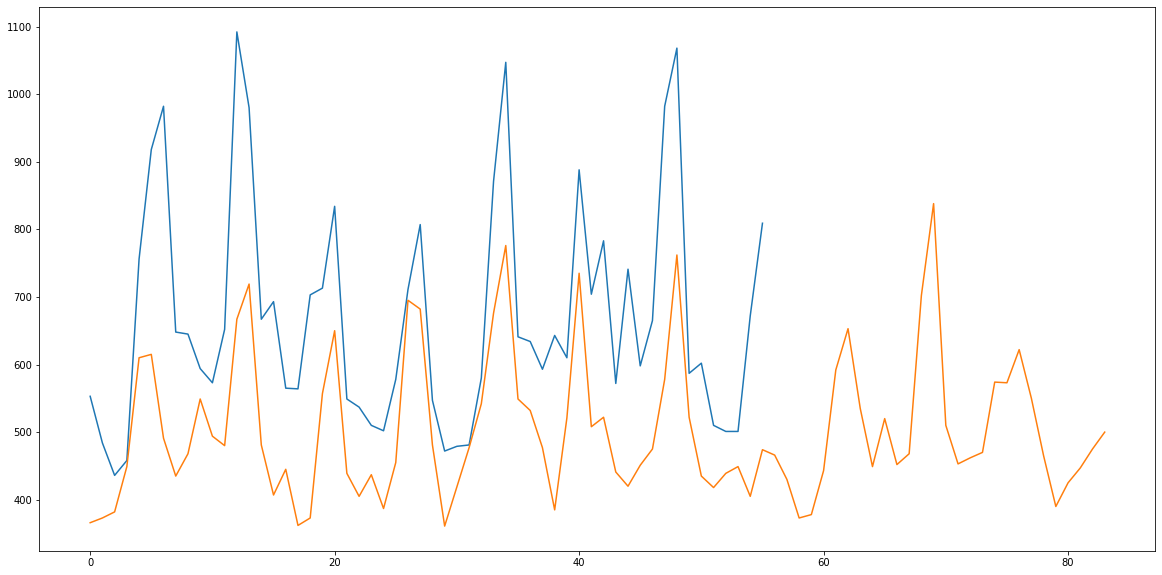

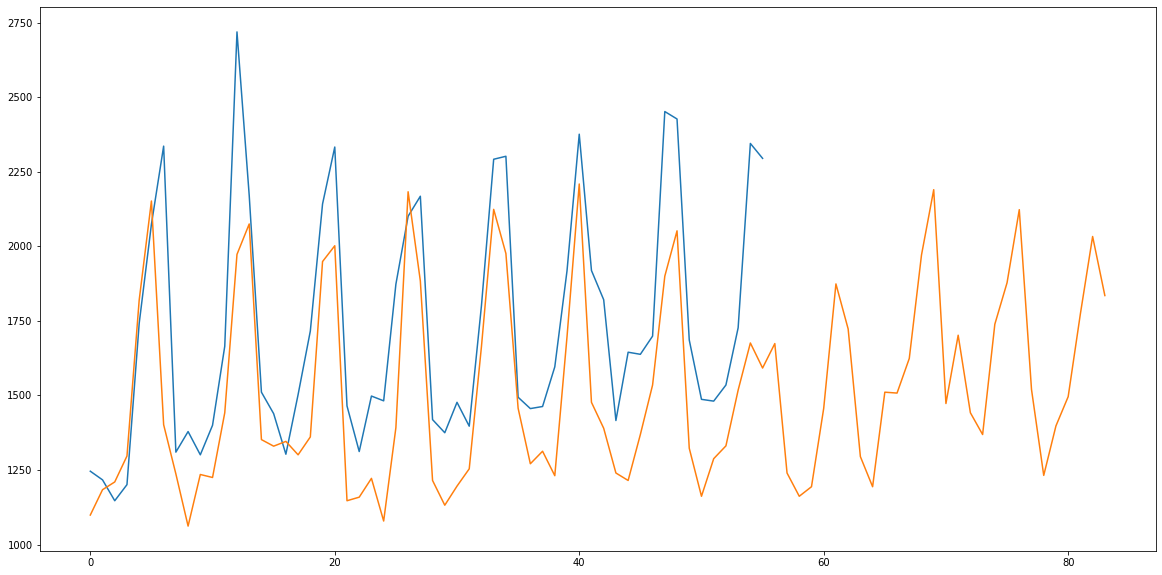

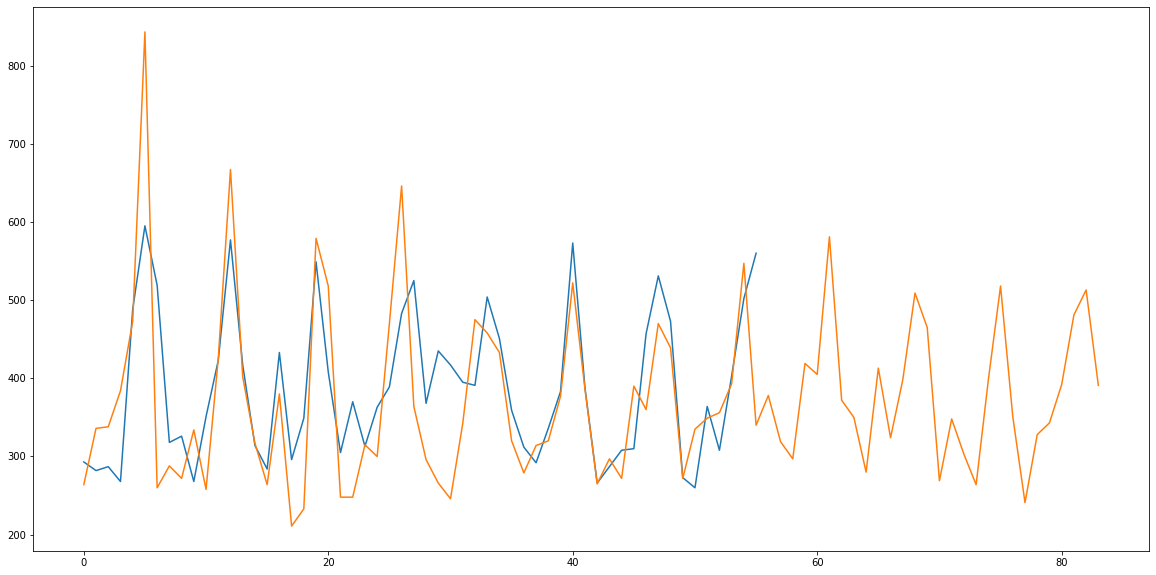

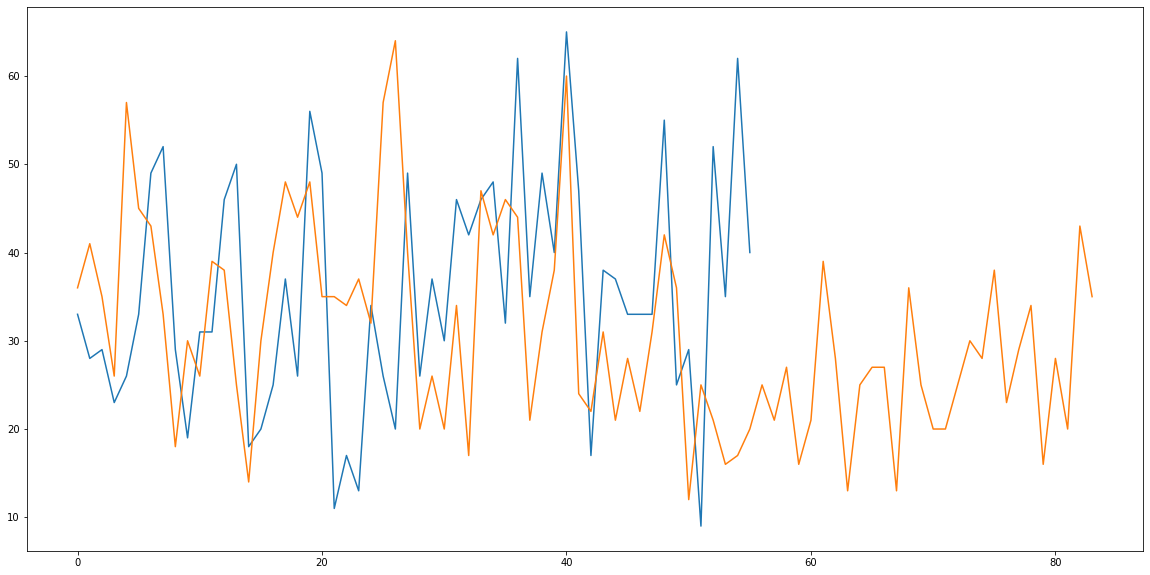

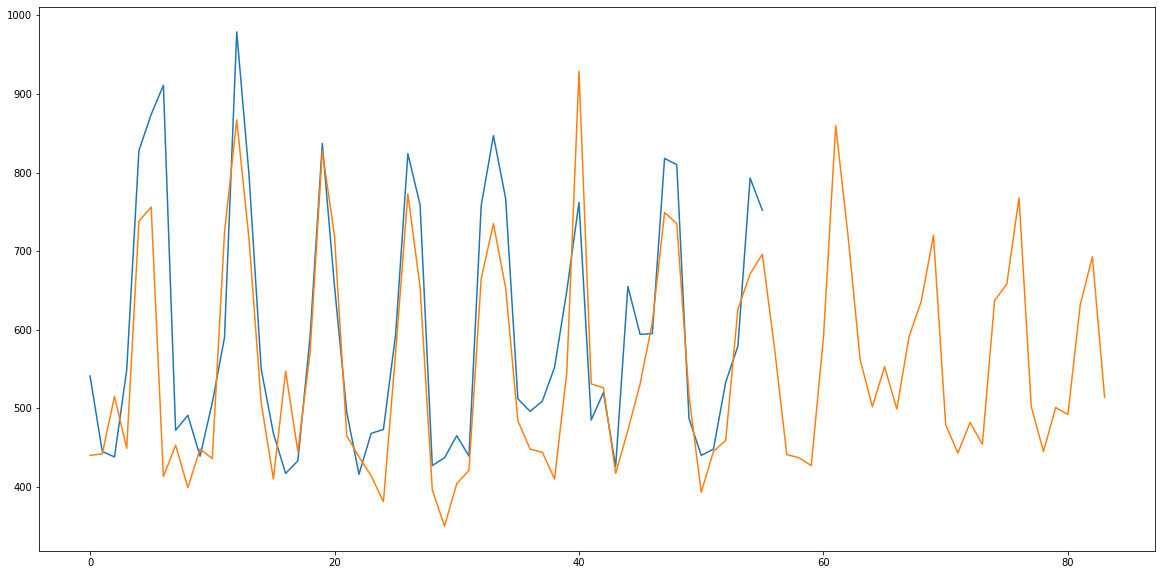

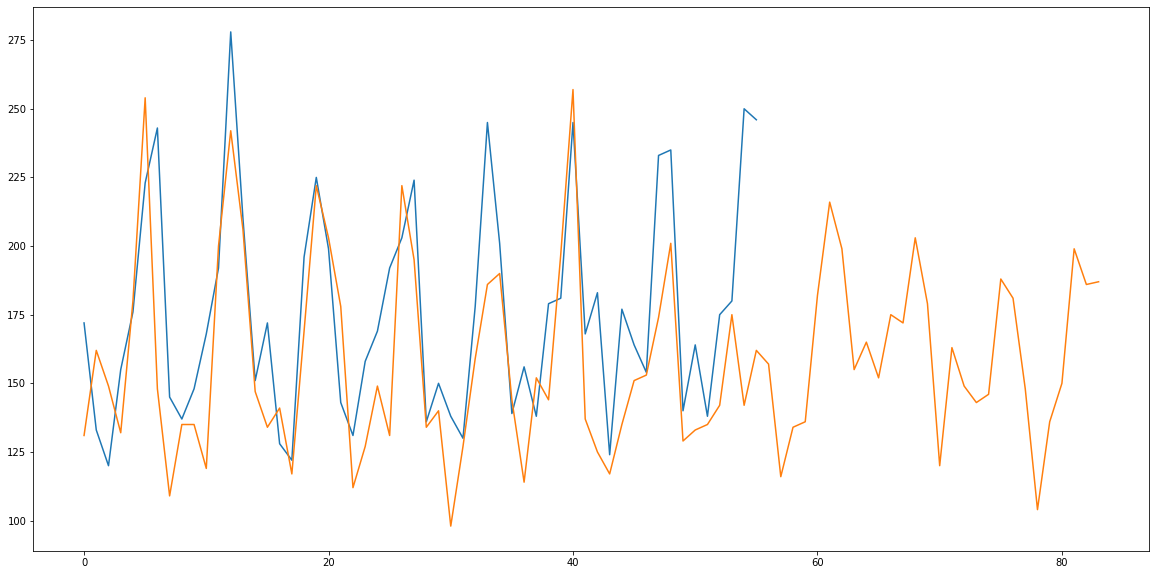

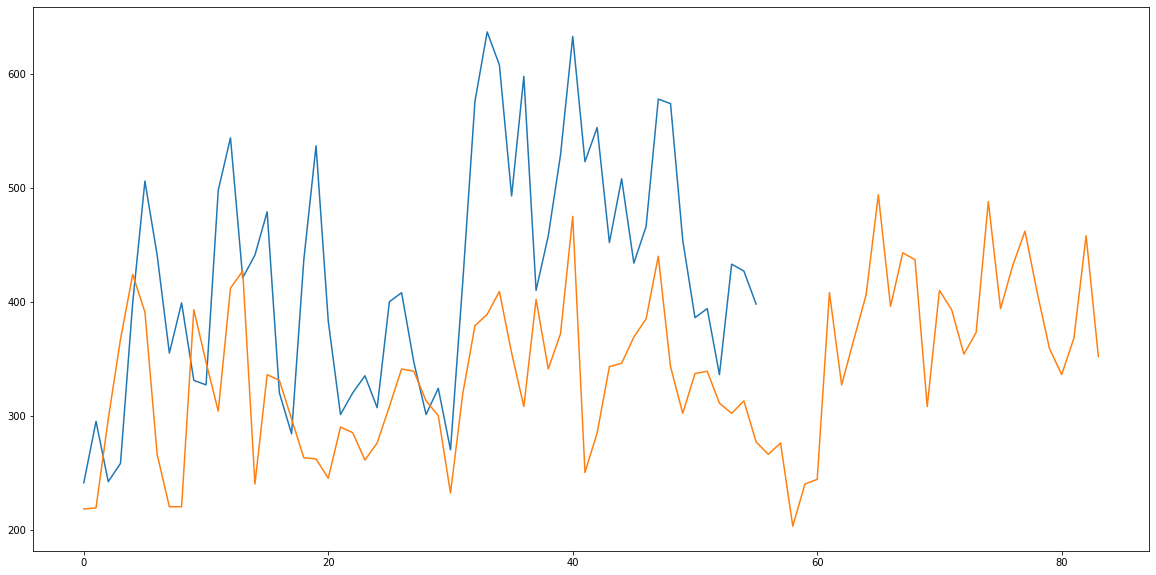

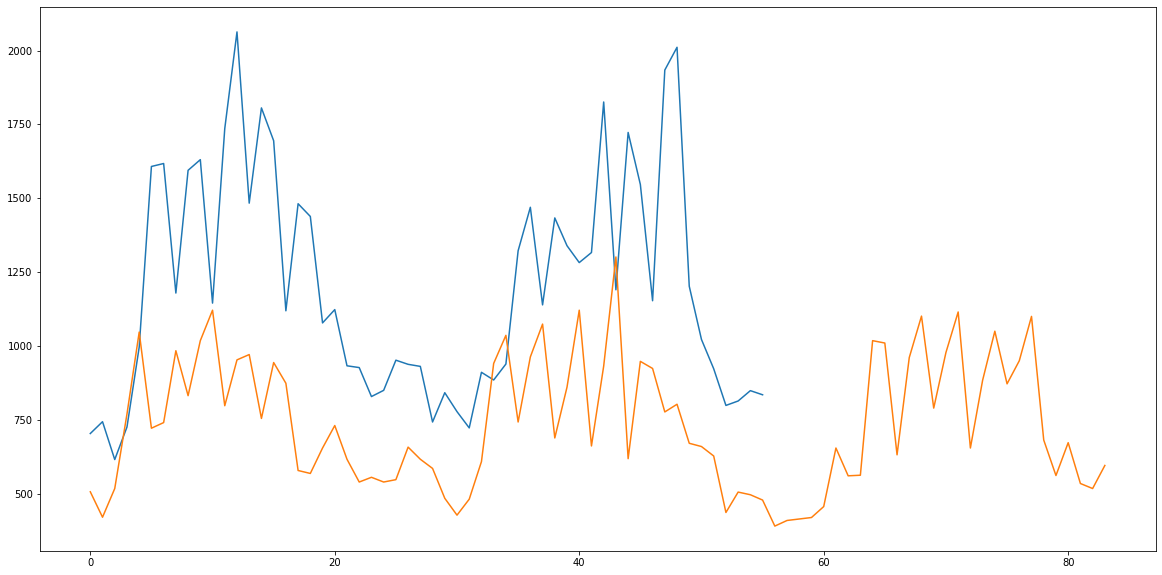

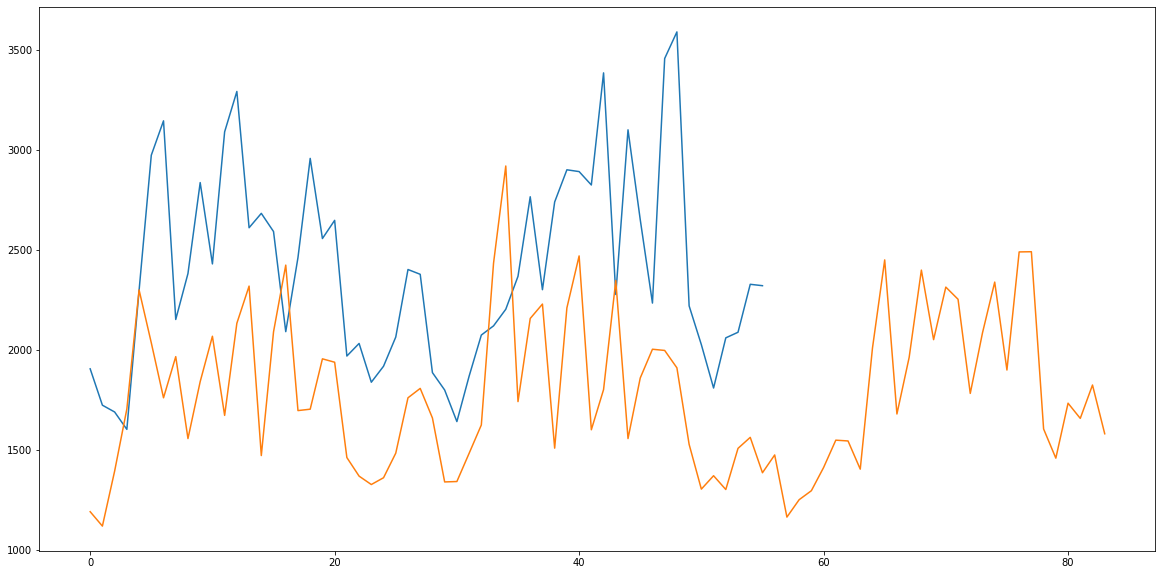

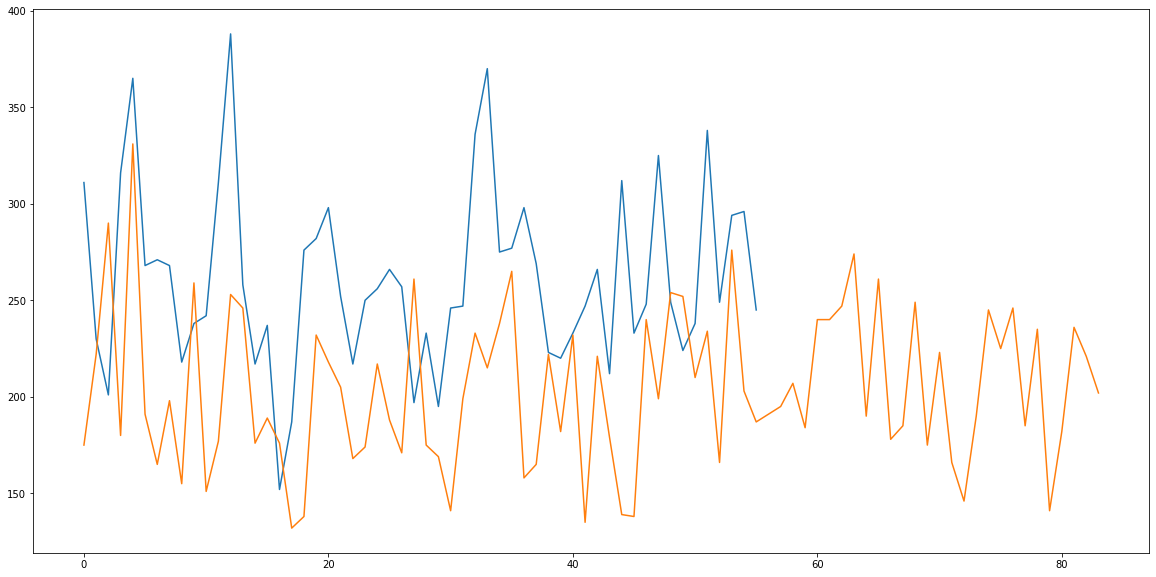

In [31]:
import matplotlib.pyplot as plt
for i in range(10):
    fig = plt.figure(figsize=(20,10))
    plt.plot(sales_array[i+50,0,-56:])
    plt.plot(sales_array[i+50,0,-(363+56):-(363-28)])
    plt.show()

In [32]:
all_sales=sales_array.sum(axis=1).sum(axis=0)

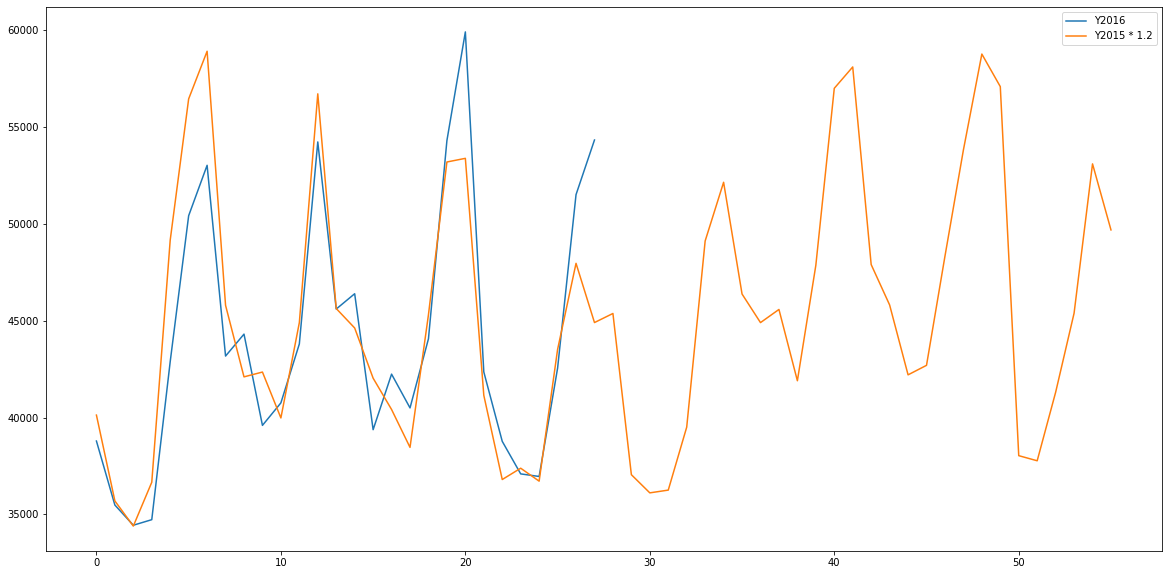

In [33]:
fig = plt.figure(figsize=(20,10))
plt.plot(all_sales[-28:],label='Y2016')
plt.plot(all_sales[-(363+28):-(363-28)]*1.2,label='Y2015 * 1.2')
plt.legend()
plt.show()